<a href="https://colab.research.google.com/github/nikkernoodle/shark-id/blob/models/Efficientnet_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS

In [3]:
#check tensorflow versions
!pip freeze | grep tensorflow

tensorflow==2.12.0
tensorflow-datasets==4.9.2
tensorflow-estimator==2.12.0
tensorflow-gcs-config==2.12.0
tensorflow-hub==0.13.0
tensorflow-io-gcs-filesystem==0.32.0
tensorflow-metadata==1.13.1
tensorflow-probability==0.20.1


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [5]:
from tensorflow.keras import layers, models, metrics, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys
import cv2
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB2, EfficientNetB3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions


# PREPROCESSING

In [6]:
def load_sharks_data(loading_method):
    if loading_method == 'colab':
        data_path = '/content/drive/My Drive/shark-datasets/sharks'
    elif loading_method == 'direct':
        data_path = '../raw_data/sharks/'
    classes = {'basking': 0, 'blue': 1, 'hammerhead': 2, 'mako': 3, 'sand tiger': 4, 'tiger': 5, 'white' : 6,
               'blacktip': 7 , 'bull': 8, 'lemon':9 , 'nurse': 10, 'thresher': 11, 'whale': 12, 'whitetip': 13}
    imgs = []
    labels = []
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl))]
        for img in tqdm(images_path[:300]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = image.resize((224, 224))
                image = cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2RGB)
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)

    # Finally we shuffle:
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    first_split = int(len(imgs) /6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]

    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_sharks_data("colab")

100%|██████████| 125/125 [00:08<00:00, 15.54it/s]


# MODEL

## Define model

In [9]:
def load_model():

    model = EfficientNetB2(weights="imagenet", include_top=False, input_shape=X_train[0].shape)

    return model

    # tf.keras.applications.efficientnet.EfficientNetB2(
    # include_top=True,
    # weights='imagenet',
    # input_tensor=None,
    # input_shape=None,
    # pooling=None,
    # classes=1000,
    # classifier_activation='softmax',
    # **kwargs

In [10]:
model = load_model()
model.summary()

31790344/31790344 [==============================] - 0s 0us/step
Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescal

In [11]:
def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False

    return model

In [12]:
model = set_nontrainable_layers(model)
model.summary()

Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0

### Actually build the model

In [13]:
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    # $CHALLENGIFY_BEGIN
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(50, activation='relu')
    prediction_layer = layers.Dense(14, activation='softmax')
#chanted dense from 500 to 50

    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])
    # $CHALLENGIFY_END
    return model

In [14]:
model = add_last_layers(model)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 flatten (Flatten)           (None, 68992)             0         
                                                                 
 dense (Dense)               (None, 50)                3449650   
                                                                 
 dense_1 (Dense)             (None, 14)                714       
                                                                 
Total params: 11,218,933
Trainable params: 3,450,364
Non-trainable params: 7,768,569
_________________________________________________________________


## Compile EfficientnetB2 + layers

In [74]:
def build_model():

    model = load_model()
    model = add_last_layers(model)

    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  weighted_metrics=['accuracy'])

    return model


## Fit the model

In [16]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 flatten_1 (Flatten)         (None, 68992)             0         
                                                                 
 dense_2 (Dense)             (None, 50)                3449650   
                                                                 
 dense_3 (Dense)             (None, 14)                714       
                                                                 
Total params: 11,218,933
Trainable params: 3,450,364
Non-trainable params: 7,768,569
_________________________________________________________________


In [18]:
model = build_model()

es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 5,
                   verbose = 1,
                   restore_best_weights = True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=16,
                    callbacks=[es])

Epoch 1/50
62/62 [==============================] - 16s 119ms/step - loss: 1.9588 - accuracy: 0.3595 - val_loss: 1.4218 - val_accuracy: 0.5631
Epoch 2/50
62/62 [==============================] - 4s 70ms/step - loss: 0.8467 - accuracy: 0.7485 - val_loss: 1.2780 - val_accuracy: 0.5534
Epoch 3/50
62/62 [==============================] - 4s 71ms/step - loss: 0.4455 - accuracy: 0.8707 - val_loss: 1.1473 - val_accuracy: 0.6214
Epoch 4/50
62/62 [==============================] - 4s 65ms/step - loss: 0.2063 - accuracy: 0.9623 - val_loss: 1.0677 - val_accuracy: 0.6602
Epoch 5/50
62/62 [==============================] - 4s 63ms/step - loss: 0.0956 - accuracy: 0.9939 - val_loss: 1.0429 - val_accuracy: 0.6828
Epoch 6/50
62/62 [==============================] - 4s 61ms/step - loss: 0.0629 - accuracy: 0.9959 - val_loss: 1.0954 - val_accuracy: 0.6699
Epoch 7/50
62/62 [==============================] - 5s 76ms/step - loss: 0.0426 - accuracy: 0.9990 - val_loss: 0.9887 - val_accuracy: 0.7120
Epoch 8/50


### Plot accuracy

In [19]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

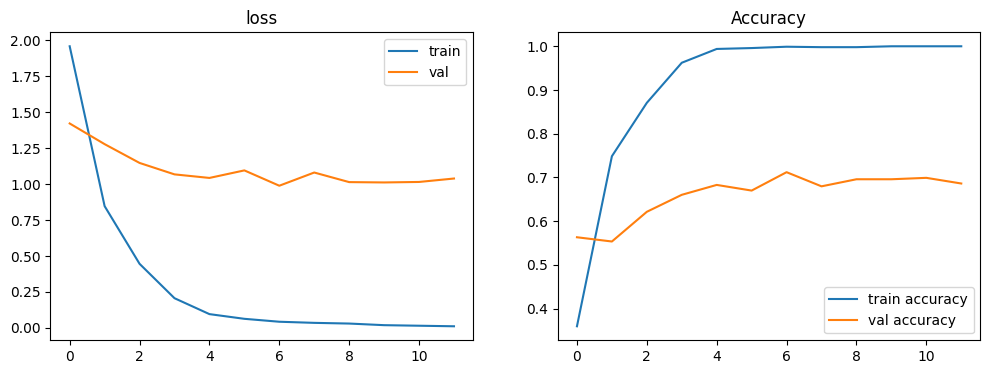

In [20]:
plot_history(history)

In [42]:
#overall accuarcy

res_vgg = model.evaluate(X_test, y_test)

test_accuracy_vgg = res_vgg[-1]


print(f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %")

# print(f"test_accuracy = {round(test_accuracy,2)*100} %")

print(f'Chance level: {1./num_classes*100:.1f}%')


9/9 [==============================] - 1s 84ms/step - loss: 1.1345 - accuracy: 0.6783
test_accuracy_vgg = 68.0 %
Chance level: 7.1%


In [22]:
predictions = model.predict(X_test)

9/9 [==============================] - 3s 86ms/step


In [24]:
y_pred = []

for pred in predictions:
  y_pred.append(np.argmax(pred))

In [25]:
y_test_argmax = []
for test in y_test:
  y_test_argmax.append(np.argmax(test))

### Classification Report for each class and overall

#### Create accuracy metric

In [76]:
# Return macro accuracy
accuracy = accuracy_score(y_test_argmax, y_pred)

# Return weighted accuracy
accuracy_bal = balanced_accuracy_score(y_test_argmax, y_pred)

accuracy, accuracy_bal

(0.6782945736434108, 0.7174780239941808)

In [35]:
from sklearn.metrics import classification_report
from sklearn import datasets, svm, metrics

In [64]:
#classification report - to tidy later

labels=['basking', 'blue', 'hammerhead', 'mako', 'sand tiger', 'tiger', 'white', 'blacktip', 'bull', 'lemon', 'nurse', 'thresher', 'whale', 'whitetip']

report = classification_report(y_test_argmax, y_pred, target_names=labels, output_dict=True)

# Convert the report to a pandas DataFrame
df = pd.DataFrame(report).transpose()
df = df.sort_values(by='precision', ascending=False)
df.reset_index(inplace=True)
df

,index,precision,recall,f1-score,support
0,basking,1.000000,0.950000,0.974359,20.000000
1,whale,0.846154,0.956522,0.897959,23.000000
2,thresher,0.826087,0.826087,0.826087,23.000000
3,hammerhead,0.789474,0.937500,0.857143,16.000000
4,sand tiger,0.777778,0.736842,0.756757,19.000000
5,nurse,0.750000,0.750000,0.750000,8.000000
6,mako,0.714286,0.588235,0.645161,17.000000
7,whitetip,0.705882,0.923077,0.800000,13.000000
8,accuracy,0.678295,0.678295,0.678295,0.678295
9,macro avg,0.677146,0.717478,0.683593,258.000000


### Confusion Matrix for class analysis

In [62]:
cm = confusion_matrix(y_test_argmax, y_pred)

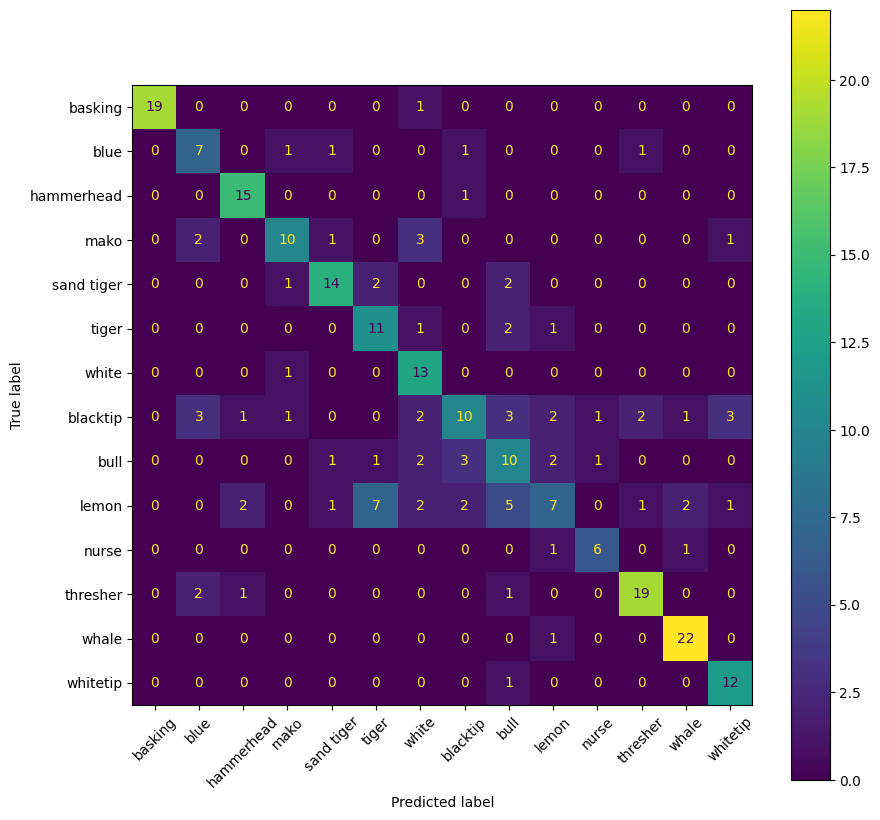

In [41]:
shark_labels = ['basking', 'blue', 'hammerhead', 'mako', 'sand tiger', 'tiger', 'white', 'blacktip', 'bull', 'lemon', 'nurse', 'thresher', 'whale', 'whitetip']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=shark_labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
ax.set_xticklabels(shark_labels, rotation=45)

plt.show()